# 2. Modeling and Predicting Fantasy Success

This notebook overviews some initial analysis with correlation and feature importance, along with simple one hot encoding positions. After three models, random forest, linear regression with elastic net, and k nearest neighbor are compared with various hyperparameters compared with split training data that’s is cross validated.

The models when picking parameters are scored to the rooted squared mean error so a predicted score can be outputted. However, When to quantify how successful the models are – they are compared against a consensus rating from fantasy football writers (raw data from 2016 – 2019 predicted rankings from [Fantasy Pros](https://www.fantasypros.com/) (data was downloaded from their API which can adjust to look at specific positions, weeks, scoring types, and more, (https://partners.fantasypros.com/api/v1/consensus-rankings.php?sport=NFL&year=2019&week=0&id=1054&position=ALL&type=ST&scoring=HALF&filters=7:8:9:285:699&export=csv)

This comparison converts each model’s outputted scores to ranking per position and is compared to the actual rankings during the season based on points per game. This ranking is compared against the consensus ranking and the error mean absolute error is compared to not penalize outliers too heavily due to the turbulent nature of injuries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

In [2]:
x_4 = pd.read_csv("data_output/4_years_x.csv", index_col=0)
y_4 = pd.read_csv("data_output/4_years_y.csv", index_col=0)

x_2 = pd.read_csv("data_output/2_years_x.csv", index_col=0)
y_2 = pd.read_csv("data_output/2_years_y.csv", index_col=0)

x_2020 = pd.read_csv("data_output/2020_x.csv", index_col=0)

## 2.1 Correlation Matrix vs. Half PPR

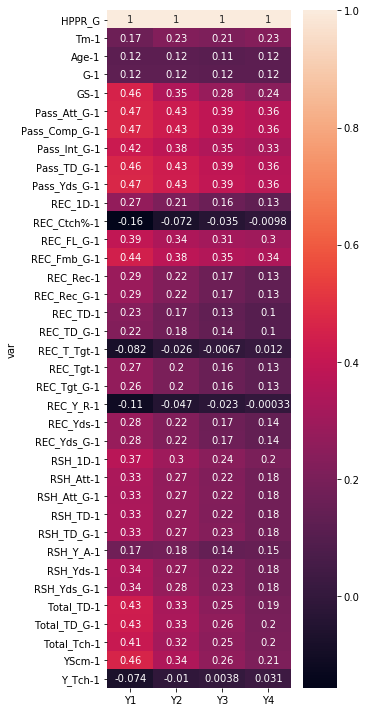

In [3]:
def correlation_hppr(x_, y_):
    x1 = x_.iloc[:,4:40]
    x2 = x_.iloc[:,40:76]
    x3 = x_.iloc[:,76:112]
    x4 = x_.iloc[:,112:148]

    cor_hppr = pd.DataFrame(list(range(len(x1.columns)+1)), columns=["key"])
    cor_hppr["var"] = ["HPPR_G"] + list(x1.columns)
    count = 1
    for x in [x1, x2, x3, x4]:
        year = ("%s-YearBack" % count)
        full_x = pd.concat([y_, x], axis=1, sort=False)
        cor = full_x.corr()
        hppr = cor[["HPPR_G"]]
        hppr["key"] = list(range(len(hppr)))
        cor_hppr = pd.merge(cor_hppr,hppr, how="inner", on="key")
        count += 1
    cor_hppr = cor_hppr.set_index("var").drop(columns="key")
    cor_hppr.columns = ['Y1', 'Y2', "Y3", "Y4"]
    cor_hppr.to_csv("data_output/y1_y4_correlation.csv")
    plt.figure(figsize=(5,10))
    sns.heatmap(cor_hppr,annot=True)
    plt.tight_layout()

correlation_hppr(x_4, y_4)

## 2.2 Preprocess X Data

In [4]:
def preprocess_x(train_x, x_2020):
    train_x["t"] = 0
    x_2020["t"] = 1
    dfx = pd.concat([train_x, x_2020])
    dfx = dfx.drop(columns=["Player"]).reset_index(drop=True)

    ohe = OneHotEncoder(handle_unknown='ignore')
    cat_col = dfx[["Position"]]
    ohe.fit(cat_col)
    feature_col_list = list(ohe.get_feature_names())
    ohe_array = ohe.transform(dfx[["Position"]]).toarray()
    dfx_ohe = pd.DataFrame(ohe_array, columns=feature_col_list)
    dfx= dfx.reset_index(drop=True)
    dfx = pd.concat([dfx_ohe, dfx], axis=1, sort=False)

    train_x = dfx[dfx["t"] == 0].drop(columns=["t", "Tm", "Position"]).reset_index(drop=True)
    x_2020 = dfx[dfx["t"] == 1].drop(columns=["t", "Tm", "Position"]).reset_index(drop=True)
    
    return train_x, x_2020

x_4_adj, x2020_adj = preprocess_x(x_4, x_2020)
x_2_adj, x2020_adj = preprocess_x(x_2, x_2020)

print((list(x_2_adj.columns)))
print(len(list(x2020_adj.columns)))

['x0_QB', 'x0_RB', 'x0_TE', 'x0_WR', 'Year', 'Tm-1', 'Age-1', 'G-1', 'GS-1', 'Pass_Att_G-1', 'Pass_Comp_G-1', 'Pass_Int_G-1', 'Pass_TD_G-1', 'Pass_Yds_G-1', 'REC_1D-1', 'REC_Ctch%-1', 'REC_FL_G-1', 'REC_Fmb_G-1', 'REC_Rec-1', 'REC_Rec_G-1', 'REC_TD-1', 'REC_TD_G-1', 'REC_T_Tgt-1', 'REC_Tgt-1', 'REC_Tgt_G-1', 'REC_Y_R-1', 'REC_Yds-1', 'REC_Yds_G-1', 'RSH_1D-1', 'RSH_Att-1', 'RSH_Att_G-1', 'RSH_TD-1', 'RSH_TD_G-1', 'RSH_Y_A-1', 'RSH_Yds-1', 'RSH_Yds_G-1', 'Total_TD-1', 'Total_TD_G-1', 'Total_Tch-1', 'YScm-1', 'Y_Tch-1', 'Tm-2', 'Age-2', 'G-2', 'GS-2', 'Pass_Att_G-2', 'Pass_Comp_G-2', 'Pass_Int_G-2', 'Pass_TD_G-2', 'Pass_Yds_G-2', 'REC_1D-2', 'REC_Ctch%-2', 'REC_FL_G-2', 'REC_Fmb_G-2', 'REC_Rec-2', 'REC_Rec_G-2', 'REC_TD-2', 'REC_TD_G-2', 'REC_T_Tgt-2', 'REC_Tgt-2', 'REC_Tgt_G-2', 'REC_Y_R-2', 'REC_Yds-2', 'REC_Yds_G-2', 'RSH_1D-2', 'RSH_Att-2', 'RSH_Att_G-2', 'RSH_TD-2', 'RSH_TD_G-2', 'RSH_Y_A-2', 'RSH_Yds-2', 'RSH_Yds_G-2', 'Total_TD-2', 'Total_TD_G-2', 'Total_Tch-2', 'YScm-2', 'Y_Tch-2

## 2.3 Feature Importance RFR

In [5]:
from sklearn.ensemble import RandomForestRegressor

def feature_importance(x, y):
    features = pd.DataFrame()
    features['feature'] = x.columns
    feat_hue = []
    for row in features["feature"]:
        end = str(row)[-2:]
        if end in ["-1", "-2", "-3", "-4"]:
            end = str(row)[-1:] + " Year Ago"
            feat_hue.append(end)
        else:
            feat_hue.append("Position / Year")
    features["hue"] = feat_hue
    reg = RandomForestRegressor(random_state=0).fit(x, y)
    features['importance'] = reg.feature_importances_
    features.sort_values(by=['importance'], ascending=False, inplace=True)
    return features

features = feature_importance(x_4_adj, y_4)

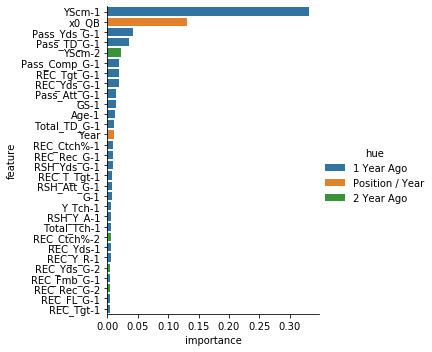

In [6]:
sns.catplot(x="importance", y="feature", data=features.head(30), kind="bar", orient="h", hue="hue", dodge=False)

## 2.4 Model Selection and Hyperparameters

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x_2_adj, y_2, test_size=0.25, random_state=1)

In [9]:
def check_models_cv(classifier, X_train, X_test, y_train, y_test):
    rscv = RandomizedSearchCV(
        classifier[0],
        param_distributions=classifier[2],
        scoring="neg_root_mean_squared_error",
        n_iter=30,
        cv=5,
        verbose=1,
        n_jobs=4,
    )
    
    rscv.fit(X_train, y_train)

    y_pred = rscv.best_estimator_.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5

    clf_summary = [classifier[1], rscv.best_score_, rmse, rscv.best_estimator_]

    return clf_summary

In [10]:
RFR_clf = [
    RandomForestRegressor(random_state=1),
    "RFR",
    {
        "max_depth": [5, 7, 9, None],
        "min_samples_split": range(2, 5),
        "n_estimators": range(30, 101, 10),
    },
]

RFR_best = check_models_cv(RFR_clf, X_train, X_test, y_train, y_test)
RFR_best

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   52.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  2.9min finished


['RFR',
 -3.1847325380690465,
 3.129843292066468,
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=4, min_weight_fraction_leaf=0.0,
                       n_estimators=80, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)]

In [11]:
LR_EN = [
    ElasticNet(random_state=1),
    "RFR",
    {
        "alpha": [x * 0.1 for x in range(0, 11, 1)],
        "l1_ratio": [x * 0.1 for x in range(0, 11, 1)],
    },
]

EN_best = check_models_cv(LR_EN, X_train, X_test, y_train, y_test)
EN_best

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   13.5s finished


['RFR',
 -3.1417943366650194,
 3.1496119439404517,
 ElasticNet(alpha=0.0, copy_X=True, fit_intercept=True, l1_ratio=0.8,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=1, selection='cyclic', tol=0.0001, warm_start=False)]

In [12]:
KNN = [
    KNeighborsRegressor(),
    "RFR",
    {
        "n_neighbors": range(3, 20, 2),
        "leaf_size": range(10, 41, 5),
    },
]

KNN_best = check_models_cv(KNN, X_train, X_test, y_train, y_test)
KNN_best

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.1s finished


['RFR',
 -3.3906001375338177,
 3.483525973815519,
 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')]

In [13]:
models =[("RFR", RFR_best[3]), ("EN", EN_best[3])]
ensemble = VotingRegressor(models)

## 2.5 Predict and Compare to Professional Rankings

In [14]:
def clean_names(df):
    name_list = []
    for name in df["Player"]:
        if name == "Mitch Trubisky":
            name = "Mitchell Trubisky"
        name_adj = str(name).replace("*", "").replace("+", "").replace(".", "")
        name_adj = name_adj.strip()
        name_adj = re.sub(' +', ' ', name_adj)
        name_split = name_adj.split()
        for x in name_split:
            if x.lower() in ["iii", "ii", "iv", "v", "jr"]:
                name_split.remove(x)
        name_adj = ' '.join(name_split)
        name_list.append(name_adj)
    df["Player"] = name_list
    return df

def pull_prof_ff_rank(year, pos):
    df = pd.read_csv("data_raw/%s%s.csv" % (year, pos), skiprows=2)
    df = df.rename(columns = {'Rank':'Player'})
    ranks = list(range(1,len(df)+1))
    df["Prof_Rk"] = ranks
    df = df[["Player", "Prof_Rk"]]
    df = clean_names(df)
    return df

In [15]:
def score_ranks(yearly_df, pos):
    if pos in ["RB", "WR"]:
        n = 24
    elif pos in ["QB", "TE"]:
        n = 12
    rk = list(yearly_df["Rk"].head(n))
    pred = list(yearly_df["Pred_Rk"].head(n))
    prof = list(yearly_df["Prof_Rk"].head(n))
    pred_mae = 0
    prof_mae = 0
    for x in range(n):
        pred_mae += abs(rk[x] - pred[x])
        prof_mae += abs(rk[x] - prof[x])
    return pred_mae/n, prof_mae/n


def predict_year(year, x, x_full, y, model):
    full_train = pd.concat([y, x], axis=1, sort=False)
    set_2019 = full_train[full_train["Year"] == year]
    x_2019 = set_2019.drop(columns=["HPPR_G"])
    y_2019 = pd.DataFrame(set_2019["HPPR_G"])

    train_no_2019 = full_train[full_train["Year"] != year]
    x_no_2019 = train_no_2019.drop(columns=["HPPR_G"])
    y_no_2019 = train_no_2019["HPPR_G"]

    reg = model.fit(x_no_2019, y_no_2019)
    pred_2019_y = list(reg.predict(x_2019))
    actual_2019_y = list(y_2019["HPPR_G"])
    #print(mean_squared_error(actual_2019_y, pred_2019_y) ** 0.5)

    y_2019["Pred_HPPR_G"] = pred_2019_y
    full_2019 = x_full[["Player", "Tm", "Position"]]
    full_2019 = y_2019.join(full_2019)
    full_2019 = full_2019.sort_values(by=['HPPR_G'], ascending=False)

    rank_full = pd.DataFrame()
    full_scores = []
    for pos in ["RB", "WR", "QB", "TE"]:
        scores = 0
        pos_df = full_2019[(full_2019["Position"] == pos)]
        ranks = list(range(1,len(pos_df)+1))
        pos_df["Rk"] = ranks

        pos_df= pos_df.sort_values(by=['Pred_HPPR_G'], ascending=False)
        pos_df["Pred_Rk"] = ranks
        
        prof_df = pull_prof_ff_rank(year, pos)
        pos_df = pd.merge(pos_df, prof_df, how="left", on="Player")
        pos_df = pos_df.fillna(max(pos_df["Prof_Rk"])+5)

        pos_df = pos_df.sort_values(by=['Rk'], ascending=True)
        pred_mae, prof_mae = score_ranks(pos_df, pos)
        scores = [pos, pred_mae, prof_mae]
        full_scores.append(scores)

        rank_full= pd.concat([rank_full, pos_df])
    full_scores = pd.DataFrame(full_scores, columns=["Pos", "Pred MAE", "Prof MAE"])
        
    return rank_full, full_scores

In [16]:
def pred_vs_prof_yearly(start_year, end_year, x, x_full, y, model):
    full_scores = pd.DataFrame()
    full_stat = pd.DataFrame()
    for year in range(start_year, end_year+1):
        full, scores = predict_year(year, x, x_full, y, model)
        scores["Year"] = year
        full_scores = pd.concat([full_scores, scores])
        full["Year"] = year
        full_stat = pd.concat([full_stat, full])
    return full_stat, full_scores

def pred_vs_prof_summary(start_year, end_year, x, x_full, y, model_list):
    full_scores = pd.DataFrame()
    full_stats = pd.DataFrame()
    for model in model_list:
        stat, scores = pred_vs_prof_yearly(start_year, end_year, x, x_full, y, model[0])
        scores["Model"] = model[1]
        full_scores = pd.concat([full_scores, scores])
        stat["Model"] = model[1]
        full_stats = pd.concat([full_stats, stat])
    full_stats.to_csv("data_output/prof_vs_pred_stats.csv")
    full_scores["Diff"] = full_scores["Prof MAE"] - full_scores["Pred MAE"]
    full_scores.to_csv("data_output/prof_vs_pred_models.csv")
    return full_scores, full_stats

## 2.6 Model Results vs. Professional Ranks

In [17]:
model_list = [
    (KNN_best[3], "KNN"),
    (RFR_best[3], "RFR"),
    (EN_best[3], "LR_EN"),
    (ensemble, "ESM")
]

full_score, full_stats = pred_vs_prof_summary(2016, 2019, x_2_adj, x_2, y_2, model_list)
full_score

,Pos,Pred MAE,Prof MAE,Year,Model,Diff
0,RB,13.666667,12.750000,2016,KNN,-0.916667
1,WR,20.833333,17.416667,2016,KNN,-3.416667
2,QB,7.250000,5.833333,2016,KNN,-1.416667
3,TE,5.833333,5.916667,2016,KNN,0.083333
0,RB,13.166667,17.541667,2017,KNN,4.375000
...,...,...,...,...,...,...
3,TE,6.666667,6.583333,2018,ESM,-0.083333
0,RB,10.666667,8.208333,2019,ESM,-2.458333
1,WR,15.875000,12.666667,2019,ESM,-3.208333
2,QB,7.166667,9.083333,2019,ESM,1.916667


In [18]:
full_score[["Model", "Diff"]].groupby(["Model"]).mean()

,Diff
Model,
ESM,0.502604
KNN,-1.184896
LR_EN,0.481771
RFR,0.169271


In [19]:
full_score[["Year", "Diff"]].groupby(["Year"]).mean()

,Diff
Year,
2016,-0.416667
2017,2.338542
2018,-0.390625
2019,-1.562500


In [20]:
full_score[["Pos", "Diff"]].groupby(["Pos"]).mean()

,Diff
Pos,
QB,0.567708
RB,0.187500
TE,0.567708
WR,-1.354167


In [21]:
full_score[["Model", "Diff", "Pos"]].groupby(["Model", "Pos"]).mean()

Diff
Model Pos          
ESM   QB   1.166667
      RB   0.802083
      TE   0.687500
      WR  -0.645833
KNN   QB  -0.541667
      RB  -1.312500
      TE   0.041667
      WR  -2.927083
LR_EN QB   0.895833
      RB   0.916667
      TE   0.812500
      WR  -0.697917
RFR   QB   0.750000
      RB   0.343750
      TE   0.729167
      WR  -1.145833

## 2.7 Predicting Success 2020 Players

In [22]:
def predict_2020(x, y, x2020_adj, x_2020, model_list):
    full_2020 = x_2020[["Player", "Tm", "Position"]]
    for model in model_list:
        reg = model[0].fit(x, y)
        pred_2020_y = list(reg.predict(x2020_adj))
        full_2020[model[1]] = pred_2020_y
        
    full_2020 = full_2020.sort_values(by="LR_EN", ascending=False)
    full_2020["KNN"]= [x[0] for x in full_2020["KNN"]]
    full_2020.to_csv("data_output/2020_pred_values.csv")
    return full_2020

pred_2020 = predict_2020(x_2_adj, y_2, x2020_adj, x_2020, model_list)
pred_2020

,Player,Tm,Position,KNN,RFR,LR_EN,ESM
19,Lamar Jackson,BAL,QB,10.567632,18.932922,23.703061,21.317991
0,Christian McCaffrey,CAR,RB,18.068421,18.088849,22.259628,20.174239
65,Deshaun Watson,HOU,QB,17.728947,19.547835,21.864452,20.706143
62,Dak Prescott,DAL,QB,16.510789,17.186947,20.302640,18.744794
31,Patrick Mahomes,KC,QB,16.560526,17.757087,20.101511,18.929299
...,...,...,...,...,...,...,...
274,Mo Alie-Cox,IND,TE,2.436316,2.343838,2.645400,2.494619
271,Kyle Juszczyk,SF,RB,4.175263,3.800216,2.623059,3.211637
248,Justin Watson,TB,WR,3.293947,2.817215,2.543916,2.680565
262,Darren Fells,HOU,TE,4.754474,4.170529,2.515599,3.343064
